In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)

eSOH_DIR = "../data/esoh/"
oCV_DIR = "../data/ocv/"
fig_DIR = "../figures/figures_fit/"
res_DIR = "../data/results_fit/"
# %matplotlib widget

In [2]:
parameter_values = get_parameter_values()

In [3]:
# parameter_values.search("Li")

In [4]:
spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        # "loss of active material": ("stress-driven","none"),
        "loss of active material": "stress-driven",
        # "stress-induced diffusion": "true",
        "lithium plating": "irreversible",
    }
)
# spm.print_parameter_info()
param=spm.param

In [5]:
cell = 4

## Load eSOH Data and OCV Data

In [6]:
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)

In [7]:
pybamm.set_logging_level("WARNING")
# pybamm.set_logging_level("NOTICE")
experiment = pybamm.Experiment(
    [
        ("Discharge at "+c_rate_d+dis_set,
         "Rest for 5 min",
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50")
    ] *dfe.N.iloc[-1],
    termination="50% capacity",
#     cccv_handling="ode",
)

In [8]:
parameter_values = get_parameter_values()
parameter_values.update(
    {
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
        "Positive electrode LAM constant proportional term [s-1]": 1.27152e-07,
        "Negative electrode LAM constant proportional term [s-1]": 1.27272e-06,
        "Positive electrode LAM constant exponential term": 1.1992,
        "Negative electrode LAM constant exponential term": 1.1992,
        "SEI kinetic rate constant [m.s-1]":  4.60788219e-16, #1.08494281e-16 , 
        "EC diffusivity [m2.s-1]": 4.56607447e-19,#8.30909086e-19,
        "SEI growth activation energy [J.mol-1]": 1.87422275e+04,#1.58777981e+04,
    },
    check_already_exists=False,
)


In [9]:
all_sumvars_dict = cycle_adaptive_simulation(spm, parameter_values, experiment,SOC_0, save_at_cycles=1)

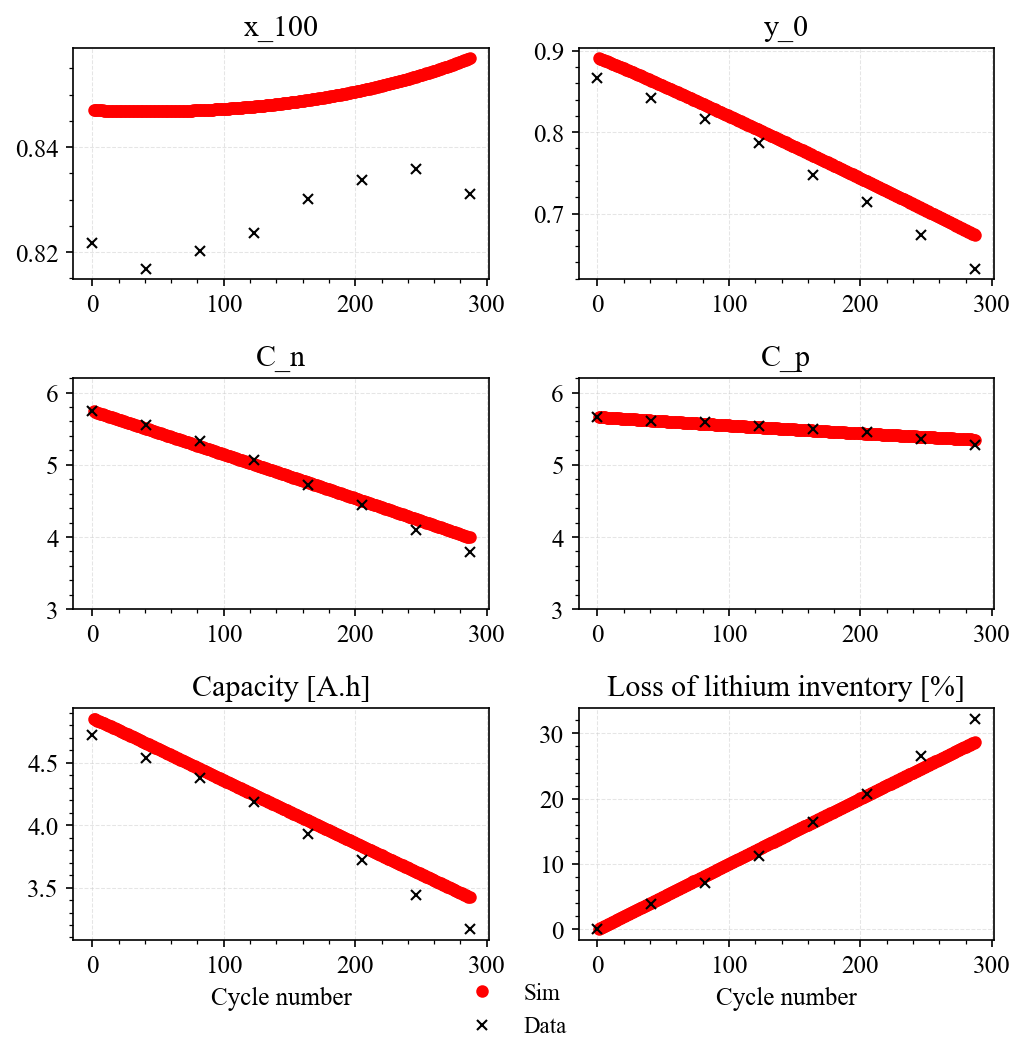

In [10]:
fig = plotc(all_sumvars_dict,dfe);
# fig.savefig(fig_DIR +'fast_sim_'+cell_no+'_new.png')

In [11]:
# fgdfdfg

# Parameter Fitting

## List of Initial Conditions

In [12]:
ic = 1
blam_p = [1e-6,1e-7,1e-8]
blam_n = [1e-5,1e-6,1e-7]
k_sei= [1*2e-16,1/5*2e-16,5*2e-16]

In [13]:
def objective(model, data):
    return np.array(model.loc[data['N_mod']]["Capacity [A.h]"]) - np.array(data["Capacity [A.h]"])

def multi_objective(model, data):
    # variables = ["C_n","C_p","x_100","y_0"]
    # weights = [1,1,5,5]
    variables = ["C_n","C_p"]
    weights = [1,1]
    # variables = ["Capacity [A.h]", "Loss of lithium inventory [%]"]
    # weights = [1,1/20]
    # variables = ["Capacity [A.h]", "Loss of lithium inventory [%]", "C_n", "C_p"]
    # weights = [1,1/20,1,1]
    return np.concatenate([
        (np.array(model.loc[data['N_mod']][var]) - np.array(data[var])) * w
        for w,var in zip(weights,variables)
    ]
    )
@timeoutable()
def simulate(x,eps_n_data,eps_p_data,SOC_0,Temp,experiment):
    parameter_values.update(
        {
            "Positive electrode LAM constant proportional term [s-1]": x[0]* blam_p[ic],
            "Negative electrode LAM constant proportional term [s-1]": x[1]*blam_n[ic],
            "Positive electrode LAM constant exponential term": x[2]*2,
            "Negative electrode LAM constant exponential term": x[3]*2,
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
            "Initial temperature [K]": 273.15+Temp,
            "Ambient temperature [K]": 273.15+Temp,
        },
        check_already_exists=False,
    )
    return cycle_adaptive_simulation(spm, parameter_values, experiment, SOC_0,save_at_cycles=1)
def prediction_error(x):
    try:
        out=[]
        for cell in [1,4]:
            cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
            eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
            # print(f"Cell: {cell_no}")
            experiment = pybamm.Experiment(
                [
                    ("Discharge at "+c_rate_d+dis_set,
                    "Rest for 5 min",
                    "Charge at "+c_rate_c+" until 4.2V", 
                    "Hold at 4.2V until C/50")
                ] *dfe.N.iloc[-1],
                termination="50% capacity",
            #     cccv_handling="ode",
            )
            # print(f"Model")
            model = simulate(x,eps_n_data,eps_p_data,SOC_0,Temp,experiment,timeout=30)
            # print(f"Objective")
            out_t =   multi_objective(pd.DataFrame(model), dfe)
            # print(f"Concat")
            out=np.concatenate([out,out_t])
        print(f"x={x}, norm={np.linalg.norm(out)}")
    # except pybamm.SolverError:
    except:
        out=[]
        for cell in [1,4]:
            cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
            # out_t = np.concatenate([np.array(dfe['Cap'])]*2)
            out_t = np.concatenate([np.array(dfe['Cap'])]*4)
            out=np.concatenate([out, out_t])
        out = 2*np.ones_like(out)
        print(f"Error")
        print(f"x={x}, norm={np.linalg.norm(out)}")
    return out

def train_model():
    timer = pybamm.Timer()
    x0 = np.array([1.0,1.0,1.0,1.0])
    # print(prediction_error(x0))
    lower = np.array([1e-3, 1e-3, 0.51, 0.51])
    upper = np.array([1e+3, 1e+3, 1, 1])
    dfo_opts = {
        "init.random_initial_directions":True,
        "init.run_in_parallel": True,
    }
    soln_dfols = dfols.solve(prediction_error, x0,bounds=(lower, upper), rhoend=1e-2, user_params=dfo_opts)
    print(timer.time())
    return soln_dfols
def sim_train(df):
    soln_dfols = train_model()
    xsol = soln_dfols.x
    # print(xsol[0]*2e-2/3600)
    # print(xsol[1]*2e-1/3600)
    # print(xsol[2]*1.6e-16)
    df['x_0'][0]=round(xsol[0],4)*blam_p[ic]
    df['x_1'][0]=round(xsol[1],4)*blam_n[ic]
    df['x_2'][0]=round(xsol[2],4)*2
    df['x_3'][0]=round(xsol[3],4)*2
    # df['obj'][0]=soln_dfols.f
    return xsol,df

In [14]:
df_x = pd.DataFrame(columns=['x_0','x_1','x_2','x_3','obj'], index=[0])

In [15]:
# sim_des = "cell_"+cell_no
# timer1 = pybamm.Timer()
train_len = len(N)
# for ic in range(0,3):
print("Initial Condition = {0}".format(ic))
x,df_x = sim_train(df_x)
# df_x.to_csv(res_DIR + "fit_train_betam_"+sim_des+'_ic'+str(ic)+".csv", index=False)

Initial Condition = 1
x=[1. 1. 1. 1.], norm=3.7458684694110747
x=[0.9402535 1.0801895 1.        1.       ], norm=3.713492718049745
x=[1.0801895 1.0597465 1.        1.       ], norm=3.7195125640900732
x=[1.  1.  0.9 1. ], norm=3.737920478687862
x=[1.  1.  1.  0.9], norm=3.5165455329497433
x=[1.00081846 1.01769032 0.99617026 0.80165512], norm=3.121114583896372
x=[1.02191522 1.27241372 0.8981488  0.51      ], norm=3.132344973834651
x=[1.01597304 1.11224724 0.92330678 0.64190456], norm=1.5665633863846378
x=[1.60719799 0.79251024 0.51       0.51      ], norm=1.2228858938127043
x=[1.41844009 1.15547984 0.99114634 0.51      ], norm=2.5036345454978624
x=[1.36010574 0.97649596 0.76513658 0.51      ], norm=1.5729151460212283
x=[1.55279224 0.77827549 0.60634245 0.51      ], norm=0.969622210828514
x=[1.39302688 1.06407755 0.86446607 0.66898464], norm=1.9840799988960276
x=[1.48788773 0.94936544 0.72339905 0.56090496], norm=0.7920192275143404
x=[2.14696539 1.04397117 0.81331381 0.51      ], norm=1.8

In [16]:
sim_des="mech_damage_4var"
df_x.to_csv(res_DIR + "cycl_train_"+sim_des+".csv")

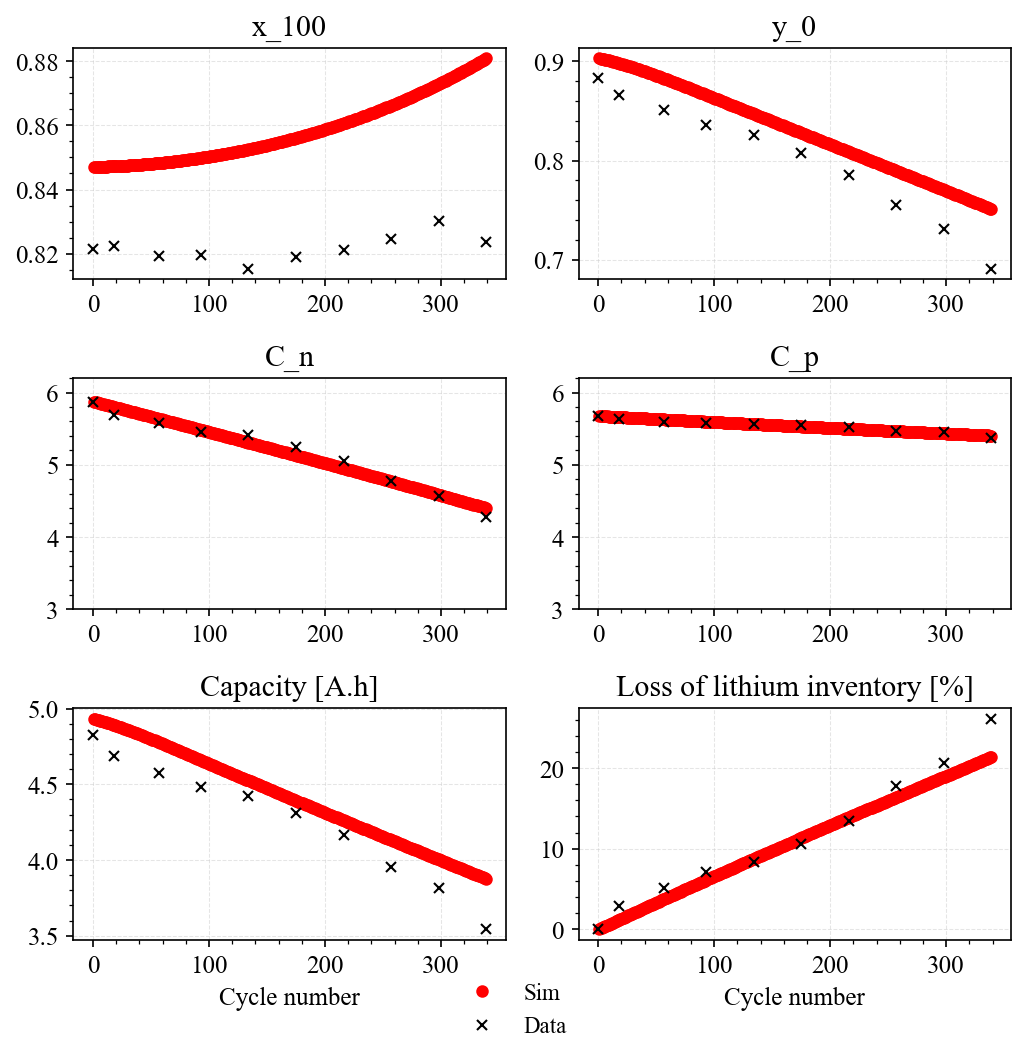

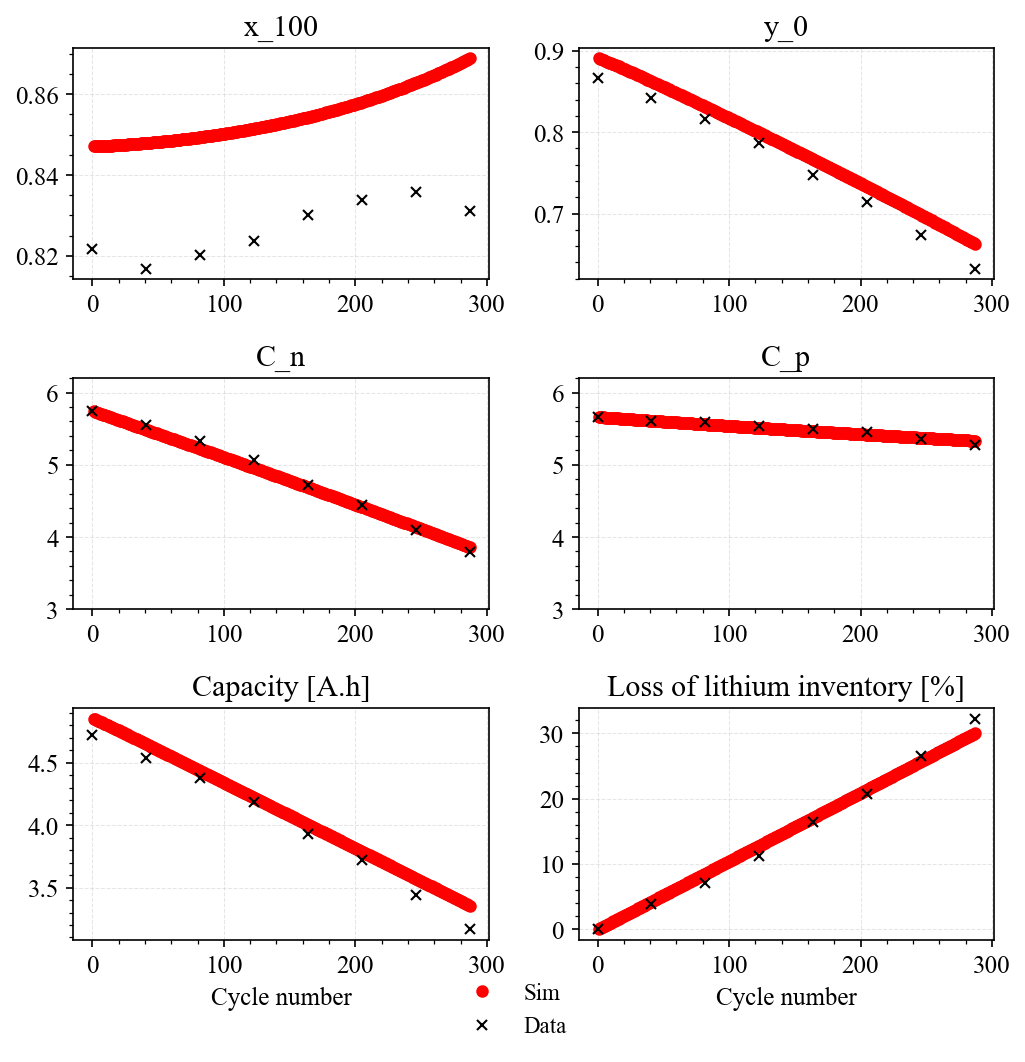

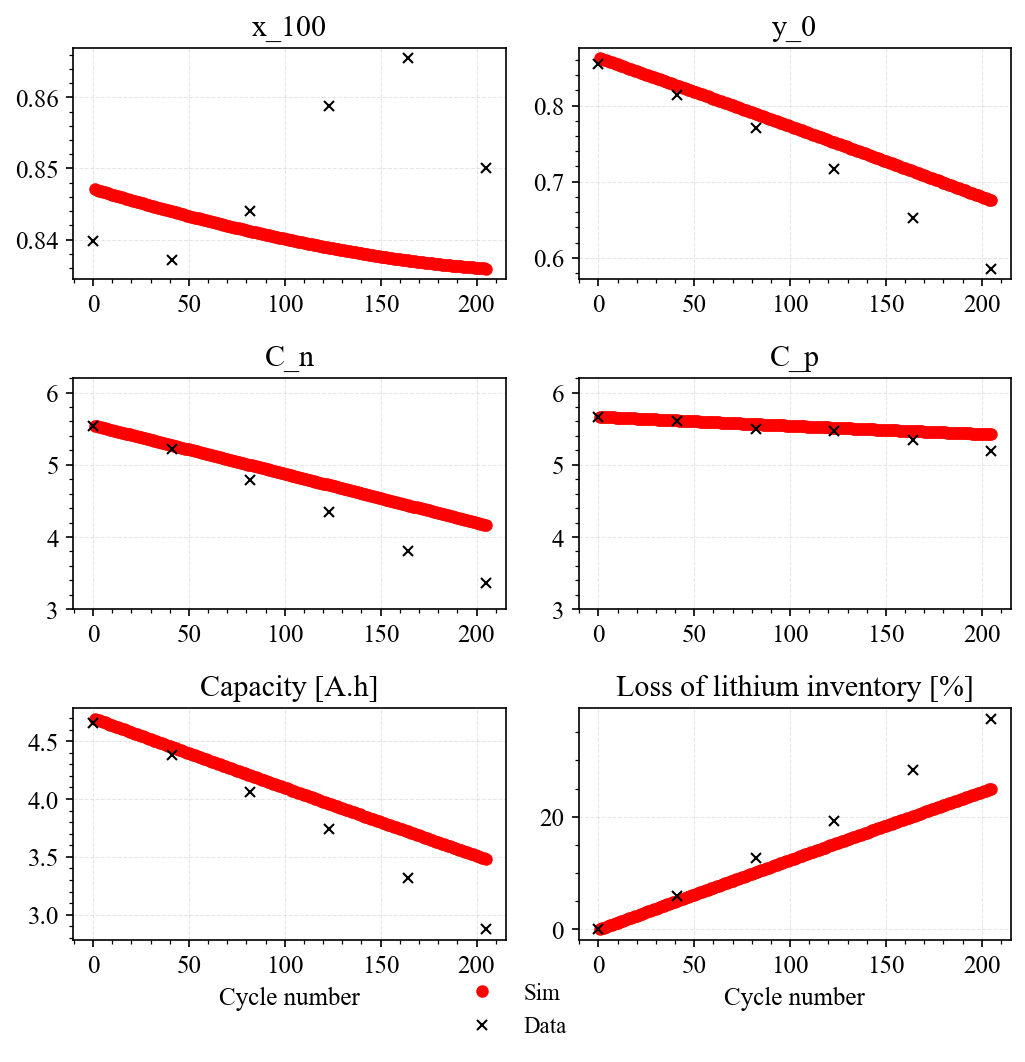

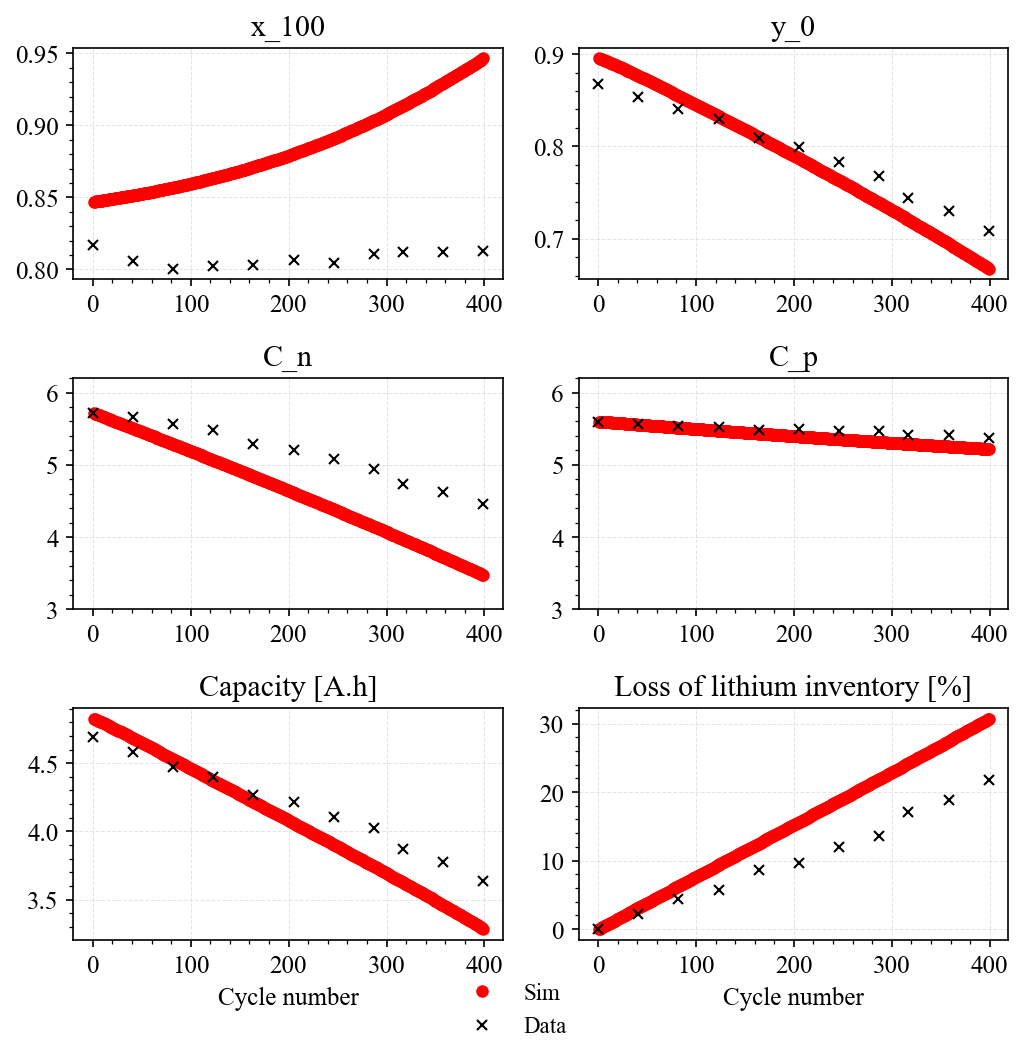

In [17]:
for cell in [1,4,7,10]:
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
    # print(f"Cell: {cell_no}")
    experiment = pybamm.Experiment(
        [
            ("Discharge at "+c_rate_d+dis_set,
            "Rest for 5 min",
            "Charge at "+c_rate_c+" until 4.2V", 
            "Hold at 4.2V until C/50")
        ] *dfe.N.iloc[-1],
        termination="50% capacity",
    #     cccv_handling="ode",
    )
    # print(f"Model")
    sol_out = simulate(x,eps_n_data,eps_p_data,SOC_0,Temp,experiment,timeout=30)
    fig = plotc(sol_out,dfe);
    plt.savefig(fig_DIR +'cycling_aging_cell_'+cell_no+'_tuning_out_4var.png')

In [18]:
x

array([1.40262646, 1.43722733, 0.61389707, 0.6153571 ])